In [189]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np

In [190]:
#reading in the dataset
df = pd.read_csv("../../../data/healthcare-dataset-stroke-data.csv")

# Two-dimensional clustering

In [191]:
df = df.fillna(df.median())

C:\Users\laise\AppData\Local\Temp/ipykernel_9776/3493596106.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [192]:
df.head(3)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21  28.1     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1

## BMI outlier handling 

In [193]:
gluc_bmi = df[["avg_glucose_level","bmi"]]
gluc_bmi.describe().round(2)

avg_glucose_level      bmi
count            5110.00  5110.00
mean              106.15    28.86
std                45.28     7.70
min                55.12    10.30
25%                77.24    23.80
50%                91.88    28.10
75%               114.09    32.80
max               271.74    97.60

In [194]:
#Outlier handling
Q1 = df["bmi"].quantile(0.25)
Q3 = df["bmi"].quantile(0.75)
IQR = Q3 - Q1
gluc_bmi = gluc_bmi.loc[(gluc_bmi['bmi'] > (Q1-(1.5*IQR))) & (gluc_bmi['bmi'] < (Q3+(1.5*IQR)))]

In [195]:
gluc_bmi.describe().round(2)

avg_glucose_level      bmi
count            4984.00  4984.00
mean              105.73    28.25
std                44.83     6.63
min                55.12    11.30
25%                77.20    23.60
50%                91.84    28.10
75%               113.76    32.30
max               271.74    46.20

In [196]:
#BMI tredshold 
BMI_min = gluc_bmi["bmi"].describe()['min']
BMI_max = gluc_bmi["bmi"].describe()['max']
BMI_scaled = (25 - BMI_min)/(BMI_max-BMI_min)


#Avg_gluc_level tredshold 
gluc_min = gluc_bmi["avg_glucose_level"].describe()['min']
gluc_max = gluc_bmi["avg_glucose_level"].describe()['max']
gluc_scaled = (150 - gluc_min)/(gluc_max-gluc_min)

## Clusters by average glucose level and bmi

In [197]:
#robust scaling
#gluc_bmi = RobustScaler().fit_transform(gluc_bmi)
#gluc_bmi = pd.DataFrame(gluc_bmi,columns=["avg_glucose_level","bmi"])
#gluc_bmi.describe().round(2)

In [198]:
#min-max scaling
#https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
gluc_bmi = MinMaxScaler().fit_transform(gluc_bmi)
gluc_bmi = pd.DataFrame(gluc_bmi,columns=["avg_glucose_level","bmi"])
gluc_bmi.describe().round(2)

avg_glucose_level      bmi
count            4984.00  4984.00
mean                0.23     0.49
std                 0.21     0.19
min                 0.00     0.00
25%                 0.10     0.35
50%                 0.17     0.48
75%                 0.27     0.60
max                 1.00     1.00

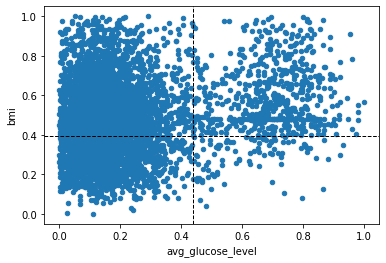

In [199]:
gluc_bmi.plot.scatter("avg_glucose_level","bmi")
plt.axvline(gluc_scaled, color='k', linestyle='dashed', linewidth=1)
plt.axhline(BMI_scaled, color='k', linestyle='dashed', linewidth=1)

### Finding the right k in k-means

In order to find the best fitting number of clusters, we evaluate different k's by the elbow and silhuette method

##### The elbow method
Distortion: Calculated as the avg of the squared distances from the cluster centers. Typically, the Euclidean distance metric is used.

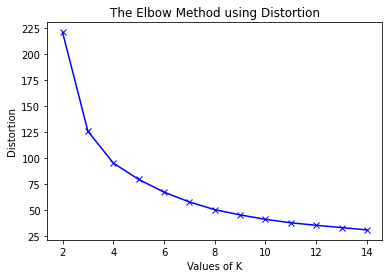

In [200]:
distortions = [] 
                 
K = range(2,15,1)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(gluc_bmi)
    kmeanModel.fit(gluc_bmi)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.savefig("two_dim_elbow.png")
plt.show()

#### The silhouette method

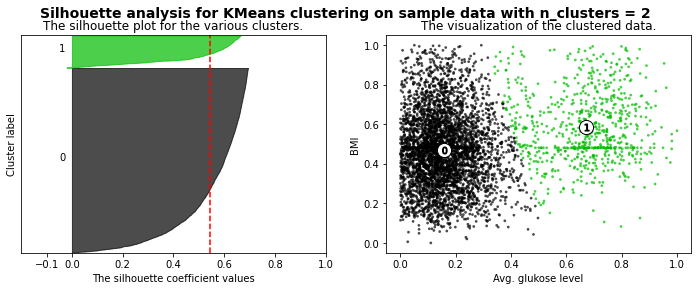

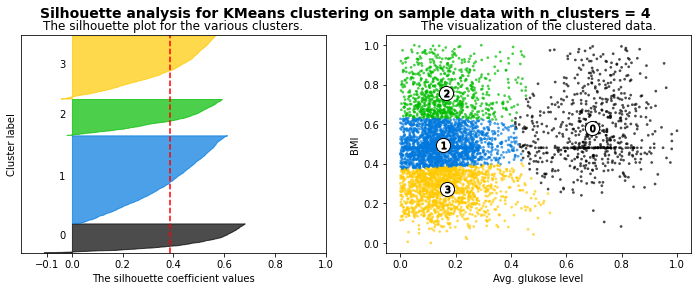

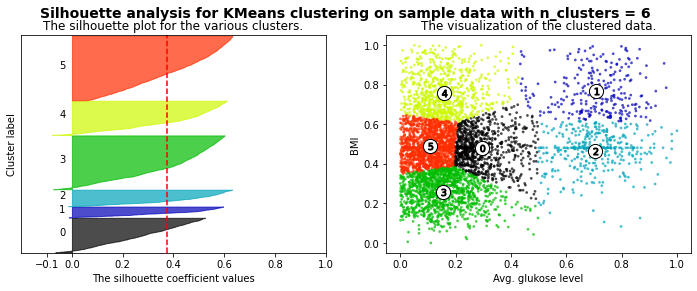

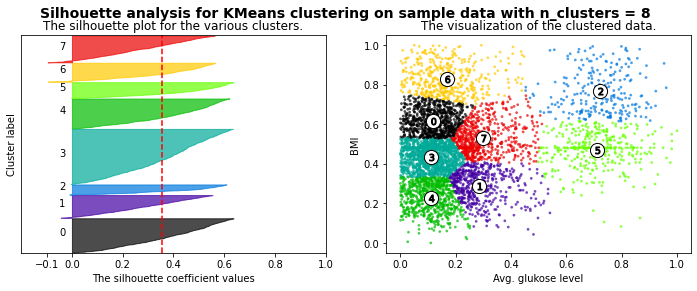

In [201]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

X = gluc_bmi

range_n_clusters = range(2,10,2)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    #print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg,)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X["avg_glucose_level"], X["bmi"], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Avg. glukose level")
    ax2.set_ylabel("BMI")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.savefig("two_dim_silhouette.png")
plt.show()

### Viewing the final k-means clusters

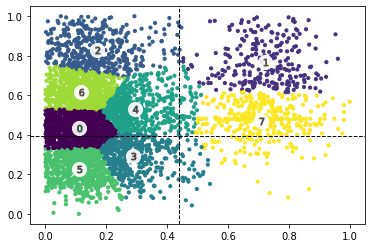

In [202]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(gluc_bmi)
y_kmeans = kmeans.predict(gluc_bmi)

plt.scatter(gluc_bmi["avg_glucose_level"], gluc_bmi["bmi"], c=y_kmeans, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=0.9)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=0.6, s=50, edgecolor="k")

plt.axvline(gluc_scaled, color='k', linestyle='dashed', linewidth=1)
plt.axhline(BMI_scaled, color='k', linestyle='dashed', linewidth=1)

## Cluster analysis 

In [203]:
gluc_bmi_stroke = df[["avg_glucose_level","bmi", "stroke"]]

In [204]:
#Outlier handling
Q1 = df["bmi"].quantile(0.25)
Q3 = df["bmi"].quantile(0.75)
IQR = Q3 - Q1
gluc_bmi_stroke = gluc_bmi_stroke.loc[(gluc_bmi_stroke['bmi'] > (Q1-(1.5*IQR))) & (gluc_bmi_stroke['bmi'] < (Q3+(1.5*IQR)))]

In [205]:
gluc_bmi_stroke = MinMaxScaler().fit_transform(gluc_bmi_stroke)
gluc_bmi_stroke = pd.DataFrame(gluc_bmi_stroke,columns=["avg_glucose_level","bmi", "stroke"])

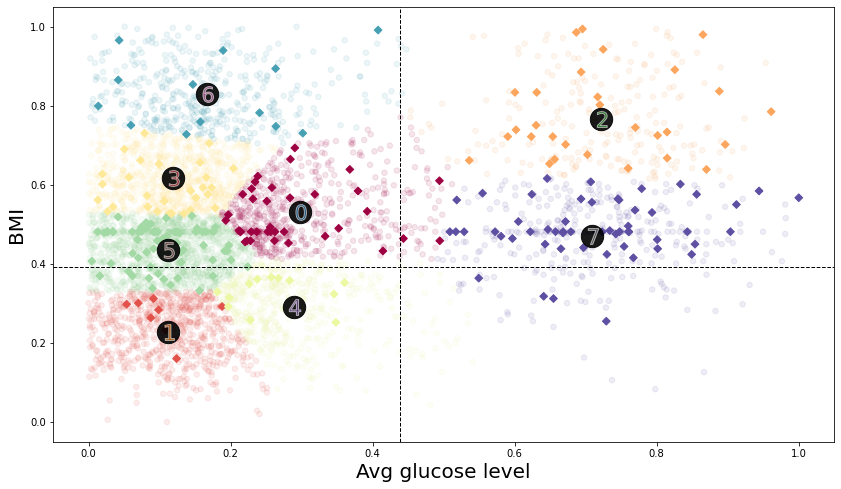

In [206]:
from matplotlib.lines import Line2D

kmeans = KMeans(n_clusters=8)
kmeans.fit(gluc_bmi_stroke[["avg_glucose_level","bmi"]])
y_kmeans = kmeans.predict(gluc_bmi_stroke[["avg_glucose_level","bmi"]])

fig, ax = plt.subplots(figsize=(14,8))

# add clusters to df
gluc_bmi_stroke["cluster"] = y_kmeans
# split df into strokes and non-strokes
non_strokes = gluc_bmi_stroke[gluc_bmi_stroke["stroke"] == 0]
strokes = gluc_bmi_stroke[gluc_bmi_stroke["stroke"] == 1]

# plot non-strokes
ax.scatter(non_strokes["avg_glucose_level"], non_strokes["bmi"], c=non_strokes["cluster"], s=30, marker='o', alpha=0.1, cmap='Spectral')

# plot strokes
scatter = ax.scatter(strokes["avg_glucose_level"], strokes["bmi"], c=strokes["cluster"], s=30, marker='D', cmap='Spectral')
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.9)

# legend for cluster numbers
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=0.6, s=250, edgecolor="white")

plt.axvline(gluc_scaled, color='k', linestyle='dashed', linewidth=1)
plt.axhline(BMI_scaled, color='k', linestyle='dashed', linewidth=1)
plt.ylabel("BMI", fontsize=20)
plt.xlabel("Avg glucose level", fontsize=20)
#plt.title(f"Cluster distribuation with 8 clusters")
plt.savefig("two_dim_k8.png")
plt.show()

In [207]:
# Calculate percentage of stroke cases for each cluster
total_strokes = strokes.shape[0]

for cluster in np.unique(y_kmeans):
    
    #share of data points
    shares = pd.DataFrame(gluc_bmi_stroke["cluster"].value_counts()/gluc_bmi_stroke.shape[0])
    shares = shares.sort_index()
    share = shares["cluster"][cluster]
    
    stroke_cases_cluster = strokes[strokes["cluster"] == cluster].shape[0]
    non_stroke_cases_cluster = non_strokes[non_strokes["cluster"] == cluster].shape[0]
    cluster_ratio = stroke_cases_cluster/(stroke_cases_cluster+non_stroke_cases_cluster)
    overall_stroke_percent = stroke_cases_cluster/total_strokes
    
    print(f"cluster {cluster}: {cluster_ratio:.2%} in cluster strokes, {overall_stroke_percent:.2%} of all strokes, {share:.2%} of all data points")

cluster 0: 6.00% in cluster strokes, 15.04% of all strokes, 12.38% of all data points
cluster 1: 1.28% in cluster strokes, 3.66% of all strokes, 14.09% of all data points
cluster 2: 12.18% in cluster strokes, 11.79% of all strokes, 4.78% of all data points
cluster 3: 3.48% in cluster strokes, 11.38% of all strokes, 16.15% of all data points
cluster 4: 2.30% in cluster strokes, 4.88% of all strokes, 10.47% of all data points
cluster 5: 4.91% in cluster strokes, 25.61% of all strokes, 25.72% of all data points
cluster 6: 2.93% in cluster strokes, 5.28% of all strokes, 8.91% of all data points
cluster 7: 14.71% in cluster strokes, 22.36% of all strokes, 7.50% of all data points


# Multidimensional clustering

In [208]:
data = df[["age","avg_glucose_level", "heart_disease", "hypertension", "stroke"]]
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data,columns=["age","avg_glucose_level", "heart_disease", "hypertension", "stroke"])
data.head(3)

age  avg_glucose_level  heart_disease  hypertension  stroke
0  0.816895           0.801265            1.0           0.0     1.0
1  0.743652           0.679023            0.0           0.0     1.0
2  0.975586           0.234512            1.0           0.0     1.0

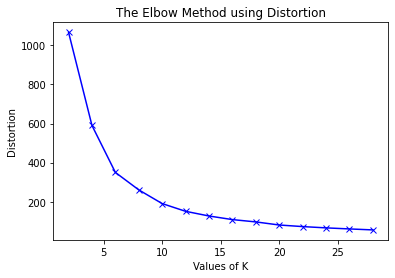

In [209]:
distortions = [] 
                 
K = range(2,30,2)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.savefig("mul_dim_elbow.png")
plt.show()

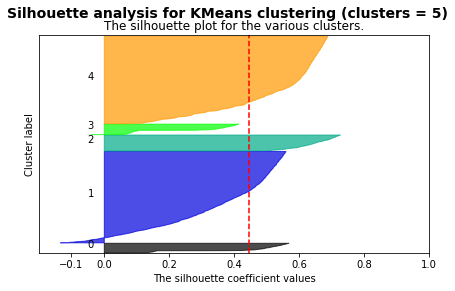

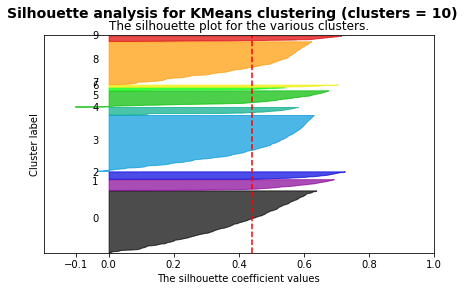

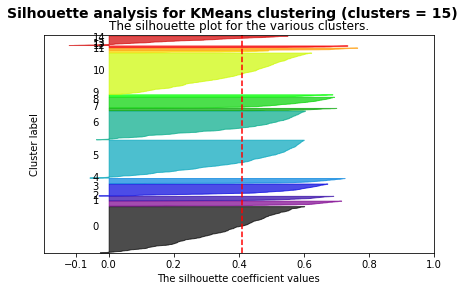

In [210]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

X = data

range_n_clusters = [5,10,15]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 4)
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering (clusters = %d)"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
    plt.savefig("mul_dim_silhouette.png")

    plt.show()

In [211]:
kmeans = KMeans(n_clusters=15)
kmeans.fit(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])
y_kmeans = kmeans.predict(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])
data["cluster"] = y_kmeans

# split into stroke and non stroke cases
non_strokes = data[data["stroke"] == 0]
strokes = data[data["stroke"] == 1]

In [212]:
def rev_min_max_func(scaled_val,target):
    max_val = max(df[target])
    min_val = min(df[target])
    val = (scaled_val*(max_val - min_val)) + min_val
    return val

In [213]:
data.head()

age  avg_glucose_level  heart_disease  hypertension  stroke  cluster
0  0.816895           0.801265            1.0           0.0     1.0       11
1  0.743652           0.679023            0.0           0.0     1.0       13
2  0.975586           0.234512            1.0           0.0     1.0        3
3  0.597168           0.536008            0.0           0.0     1.0        5
4  0.963379           0.549349            0.0           1.0     1.0       10

In [214]:
for cluster in range(data["cluster"].max()+1):
    temp = data[data["cluster"]==cluster]
    print("cluster: " + str(cluster))
    print("age_mean: " + str(round(rev_min_max_func(temp["age"].mean(),"age"),2)))
    print("gluc_mean: " + str(round(rev_min_max_func(temp["avg_glucose_level"].mean(),"avg_glucose_level"),2)))
    print("heart_dis: " + str(temp["heart_disease"].sum()))
    print("hypertension: " + str(temp["hypertension"].sum()))
    print("size: " + str(temp.shape[0]) + ", strokes: " + str(temp["stroke"].sum()))
    print("in cluster share: " + str(round(((temp["stroke"].sum()/temp.shape[0])*100),2)) + "%")
    print("share of all strokes: " + str(round(((temp["stroke"].sum()/data["stroke"].sum())*100),2)) + "%")
    print("\n")

cluster: 0
age_mean: 16.88
gluc_mean: 130.74
heart_dis: 0.0
hypertension: 0.0
size: 321, strokes: 0.0
in cluster share: 0.0%
share of all strokes: 0.0%


cluster: 1
age_mean: 73.77
gluc_mean: 88.46
heart_dis: 0.0
hypertension: 0.0
size: 500, strokes: 60.0
in cluster share: 12.0%
share of all strokes: 24.1%


cluster: 2
age_mean: 70.89
gluc_mean: 88.73
heart_dis: 0.0
hypertension: 156.0
size: 156, strokes: 24.0
in cluster share: 15.38%
share of all strokes: 9.64%


cluster: 3
age_mean: 66.81
gluc_mean: 91.71
heart_dis: 140.0
hypertension: 0.0
size: 140, strokes: 16.0
in cluster share: 11.43%
share of all strokes: 6.43%


cluster: 4
age_mean: 55.46
gluc_mean: 79.73
heart_dis: 0.0
hypertension: 0.0
size: 718, strokes: 25.0
in cluster share: 3.48%
share of all strokes: 10.04%


cluster: 5
age_mean: 42.04
gluc_mean: 207.05
heart_dis: 0.0
hypertension: 0.0
size: 156, strokes: 3.0
in cluster share: 1.92%
share of all strokes: 1.2%


cluster: 6
age_mean: 70.58
gluc_mean: 151.21
heart_dis: 64.0

## Visuals 

In [215]:
#pip install plotly

In [216]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

In [217]:
from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=3)
pca.fit(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])

# Transform the scaled data to the new PCA space
X_reduced = pca.transform(data[["age", "avg_glucose_level", "heart_disease", "hypertension"]])

# Convert to df
reduced_df = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2', 'PC3'])

# # Add clusters and strokes
reduced_df["cluster"] = y_kmeans
reduced_df["stroke"] = data["stroke"]
reduced_df["heart_disease"] = data["heart_disease"]
reduced_df["hypertension"] = data["hypertension"]

In [218]:
reduced_df.head(3)

PC1       PC2       PC3  cluster  stroke  heart_disease  hypertension
0  0.508949 -0.710741  0.708314       11     1.0            1.0           0.0
1  0.163670 -0.236083 -0.088964       13     1.0            0.0           0.0
2  0.462517 -0.709081  0.517663        3     1.0            1.0           0.0

In [219]:
for x in range(0,max(reduced_df["cluster"])+1):
    temp = reduced_df[reduced_df["cluster"]==x]
    print("Cluster: " + str(x) + ", strokes: " + str(sum(temp["stroke"])) + ", out of " + str(temp.stroke.count()))

Cluster: 0, strokes: 0.0, out of 321
Cluster: 1, strokes: 60.0, out of 500
Cluster: 2, strokes: 24.0, out of 156
Cluster: 3, strokes: 16.0, out of 140
Cluster: 4, strokes: 25.0, out of 718
Cluster: 5, strokes: 3.0, out of 156
Cluster: 6, strokes: 13.0, out of 64
Cluster: 7, strokes: 7.0, out of 136
Cluster: 8, strokes: 9.0, out of 844
Cluster: 9, strokes: 1.0, out of 644
Cluster: 10, strokes: 22.0, out of 142
Cluster: 11, strokes: 18.0, out of 72
Cluster: 12, strokes: 1.0, out of 556
Cluster: 13, strokes: 36.0, out of 242
Cluster: 14, strokes: 14.0, out of 419


In [220]:
# would also be nice to show the cluster centres, 
#but we need to apply the same PCA transformation that we gave to the actual data points, 
#so that they can appear in the new 2 dimensional PCA space
centres_reduced = pca.transform(kmeans.cluster_centers_)

In [221]:
import plotly.express as px
import plotly.io as pio
px.defaults.color_continuous_scale = px.colors.sequential.Rainbow
px.defaults.template = "ggplot2"

df = reduced_df
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='cluster')
fig.update_layout(showlegend=False)
fig.update_coloraxes(showscale=False)
camera = dict(
   eye = dict(x = 1.25, y = 1.6, z = 1.25)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [222]:
pio.write_image(fig, 'multi_dim_plotly_pca.png', width=800, height=775)

#### 2-d visual

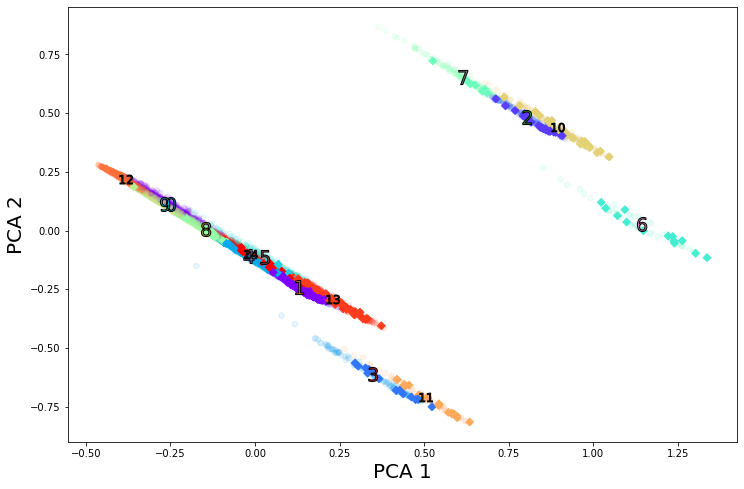

In [225]:
# Plot the results (Only works for 2 dimensions)
fig, ax = plt.subplots(figsize=(12,8))

non_strokes = reduced_df[reduced_df["stroke"] == 0]
strokes = reduced_df[reduced_df["stroke"] == 1]

# plot non-strokes
ax.scatter(non_strokes["PC1"], non_strokes["PC2"], c=non_strokes["cluster"], s=30, marker='o', alpha=0.1, cmap='rainbow')
# and strokes
scatter = ax.scatter(strokes["PC1"], strokes["PC2"], c=strokes["cluster"], s=30, marker='D', cmap='rainbow')

# centers = centres_reduced
# ax.scatter(centers[:, 0], centers[:, 1], c='grey', s=300, alpha=0.9)

# legend for cluster numbers
for i, c in enumerate(centres_reduced):
    plt.scatter(c[0], c[1], marker="$%d$" % i, s=200, edgecolor="black")

# legend for stroke/no stroke
legend_elements = [Line2D([0], [0], marker='D', label='Stroke', markersize=10),
                   Line2D([0], [0], marker='o', label='No Stroke', markersize=10),
                  ]
#legend2 = ax.legend(handles=legend_elements, loc='upper left', prop={'size': 20})
plt.xlabel("PCA 1", fontsize=20)
plt.ylabel("PCA 2", fontsize=20)
plt.savefig("mul_dim_visu.png")
plt.show()

#### PCA visuals

explanied variance summed: 0.85


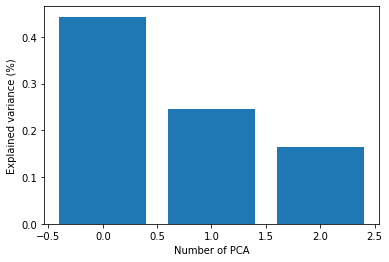

In [226]:
variance = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar([0,1,2], variance)
ax.set_ylabel("Explained variance (%)")
ax.set_xlabel("Number of PCA")

print("explanied variance summed: " + str(sum(variance).round(2)))

In [228]:
pca.components_

array([[ 0.61485317,  0.25408494,  0.26918552,  0.69637316],
       [-0.55237082, -0.15759451, -0.41493651,  0.7056048 ],
       [-0.54170218,  0.1847156 ,  0.81437408,  0.09609236]])

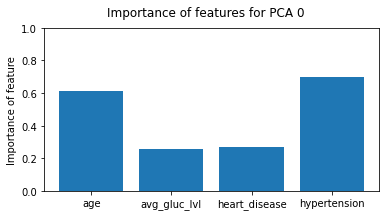

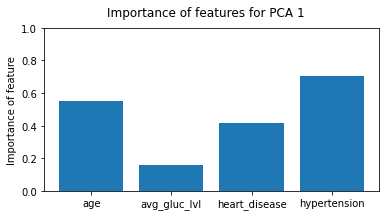

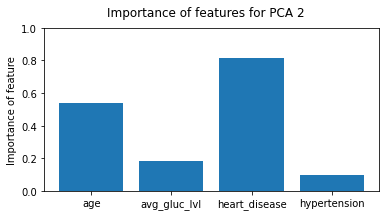

In [227]:
for c in range(3):
    abs(pca.components_)
    first_component = abs(pca.components_[c])
    x = ["age", "avg_gluc_lvl", "heart_disease", "hypertension"]
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_ylim(0, 1)    
    ax.bar(x, first_component)
    ax.set_ylabel("Importance of feature")
    fig.suptitle("Importance of features for PCA " + str(c))